<a href="https://colab.research.google.com/github/Mejayyy/AnomalyDet/blob/main/AD_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install pyod
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=2cd27efb3baede1789c45bd97cb08a82c0b77aab753becaeb2e5744e90e1587f
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from  sklearn.metrics import roc_auc_score as ras
from scipy.io import loadmat
from pyod.utils.utility import standardizer

from pyod.models.iforest import IForest as IF
from pyod.models.dif import DIF
from pyod.models.loda import LODA

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

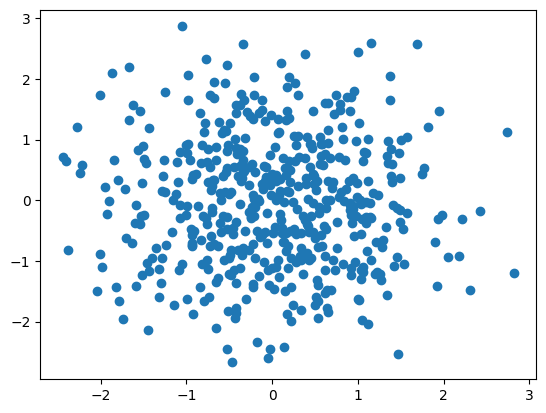

(500, 2)


In [35]:
#Ex 1.1
n=500
center=np.array([0,0])
std=1
x,_=make_blobs(n,n_features=2,centers=[center])

plt.scatter(x[:,0],x[:,1])
plt.show()

x=np.reshape(x,(500,2))
print(x.shape)


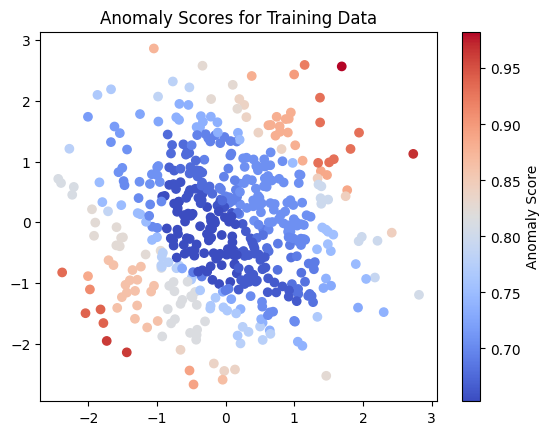

In [41]:
#Ex 1.2-3
num_projections = 5
vectori=np.random.multivariate_normal(mean=[0,0],cov=np.identity(2),size=(num_projections,1))

proj=np.zeros((500,num_projections))
histo = []
for i in range(num_projections):
    vectori[i, :] = vectori[i, :] / np.linalg.norm(vectori[i, :])  # Normalize
    proj[:, i] = np.dot(x, vectori[i, :].T).ravel()

    hist, bin_edges = np.histogram(proj[:, i], bins=10, range=(proj[:, i].min() - 3, proj[:, i].max() + 3))
    histo.append((hist, bin_edges))


probs = []
for i in range(num_projections):
    hist, bin_edges = histo[i]
    bin_width = bin_edges[1] - bin_edges[0]
    prob_density = hist / (n * bin_width)  # densitate
    prob_indices = np.digitize(proj[:, i], bin_edges) - 1
    prob_indices = np.clip(prob_indices, 0, len(prob_density) - 1)
    probs.append(prob_density[prob_indices])


anomaly_scores = np.mean(probs, axis=0)

#Plotare
plt.scatter(x[:, 0], x[:, 1], c=1-anomaly_scores, cmap="coolwarm")
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Scores for Training Data")
plt.show()




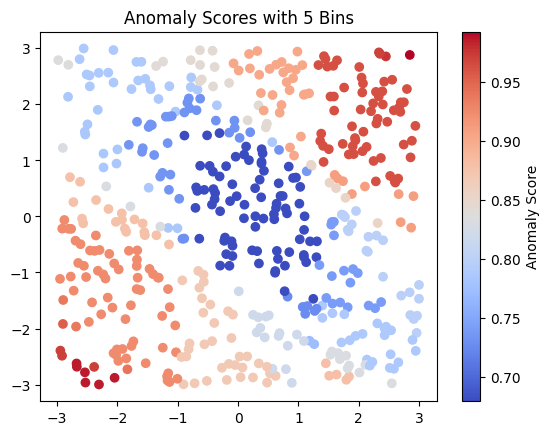

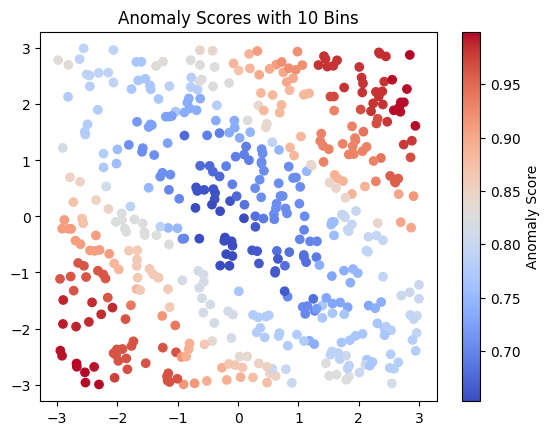

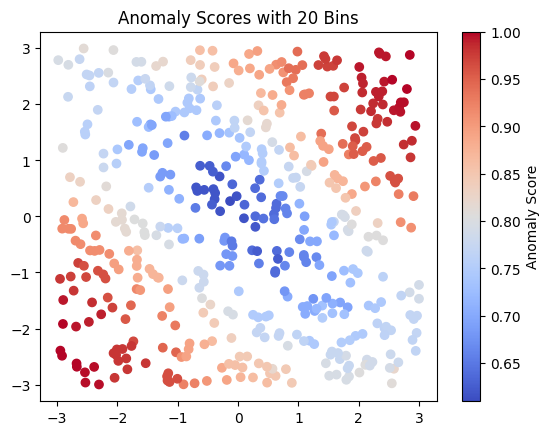

In [46]:
#Ex 1.4
test_proj = np.zeros((500, num_projections))
test_data = np.random.uniform(low=-3, high=3, size=(500, 2))

for i in range(num_projections):
    test_proj[:, i] = np.dot(test_data, vectori[i, :].T).ravel()


for bins in [5, 10, 20]:
    histo = []


    for i in range(num_projections):
        hist, bin_edges = np.histogram(proj[:, i], bins=bins, range=(proj[:, i].min() - 3, proj[:, i].max() + 3))
        histo.append((hist, bin_edges))


    test_probs = []
    for i in range(num_projections):
        hist, bin_edges = histo[i]
        bin_width = bin_edges[1] - bin_edges[0]
        prob_density = hist / (n * bin_width)
        prob_indices = np.digitize(test_proj[:, i], bin_edges) - 1
        prob_indices = np.clip(prob_indices, 0, len(prob_density) - 1)
        test_probs.append(prob_density[prob_indices])

    test_anomaly_scores = np.mean(test_probs, axis=0)

    # Plotare
    plt.scatter(test_data[:, 0], test_data[:, 1], c=1-test_anomaly_scores, cmap="coolwarm")
    plt.colorbar(label="Anomaly Score")
    plt.title(f"Anomaly Scores with {bins} Bins")
    plt.show()

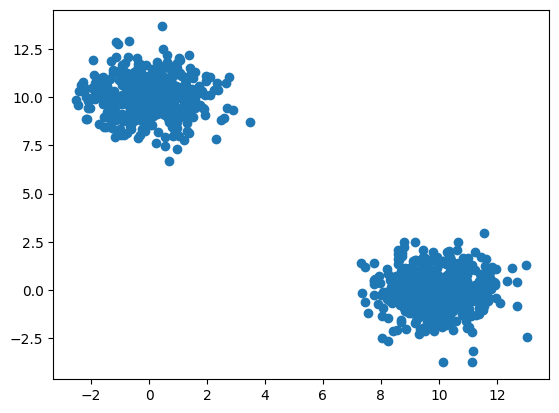

In [48]:
#Ex 2.1
miu_1=np.array([10,0])
miu_2=np.array([0,10])
x,_=make_blobs([500,500],n_features=2,centers=[miu_1,miu_2], cluster_std=[1,1])

plt.scatter(x[:,0],x[:,1])



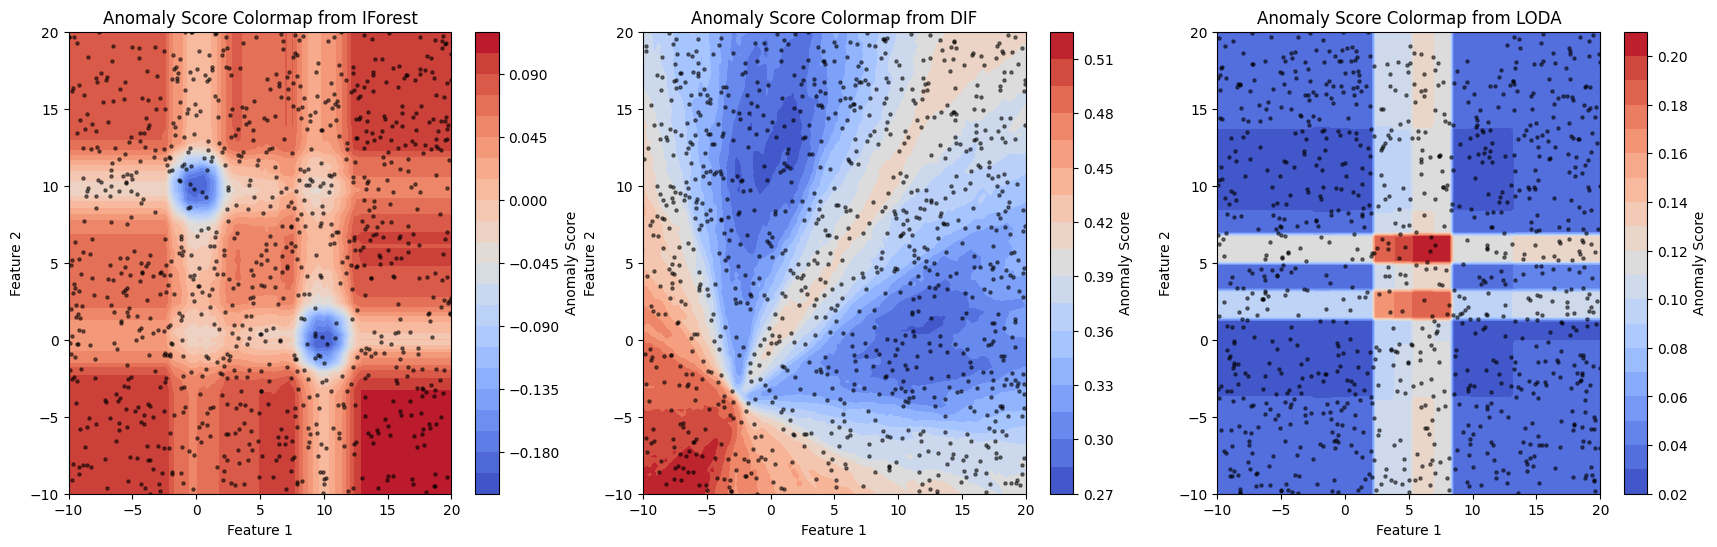

In [49]:
#Ex 2.2-4
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
def colors(p,model,neurons=0,bins=10):
  if model==IF:
    forest=model(contamination=0.02)
    nume='IForest'
  elif model== DIF:
    nume='DIF'
    if neurons!=0:
      forest=model(contamination=0.02,hidden_neurons=neurons)
    else:
      forest=model(contamination=0.02)
  elif model==LODA:
    forest=model(contamination=0.02,n_bins=bins)
    nume='LODA'


  forest=model(contamination=0.02)
  forest.fit(x)

  x_test=np.random.uniform(low=-10,high=20, size=(1000,2))

  #y_test_scores = forest.decision_function(x_test)


  # Define test grid
  x_min, x_max = -10, 20
  y_min, y_max = -10, 20
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  # Flatten the grid and calculate anomaly scores
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  z = forest.decision_function(grid_points)
  z = z.reshape(xx.shape)

  # Plot the colormap
  #plt.figure(figsize=(10, 8))
  contour = axs[p].contourf(xx, yy, z, cmap='coolwarm', levels=20)
  plt.colorbar(contour, label="Anomaly Score")
  axs[p].scatter(x_test[:, 0], x_test[:, 1], c='black', s=5, alpha=0.5)  # Overlay the original data points

  axs[p].set_title("Anomaly Score Colormap from {}".format(nume))
  axs[p].set_xlabel("Feature 1")
  axs[p].set_ylabel("Feature 2")
  #axs[p].show()

colors(p=0,model=IF)
colors(p=1,model=DIF)
colors(p=2,model=LODA)



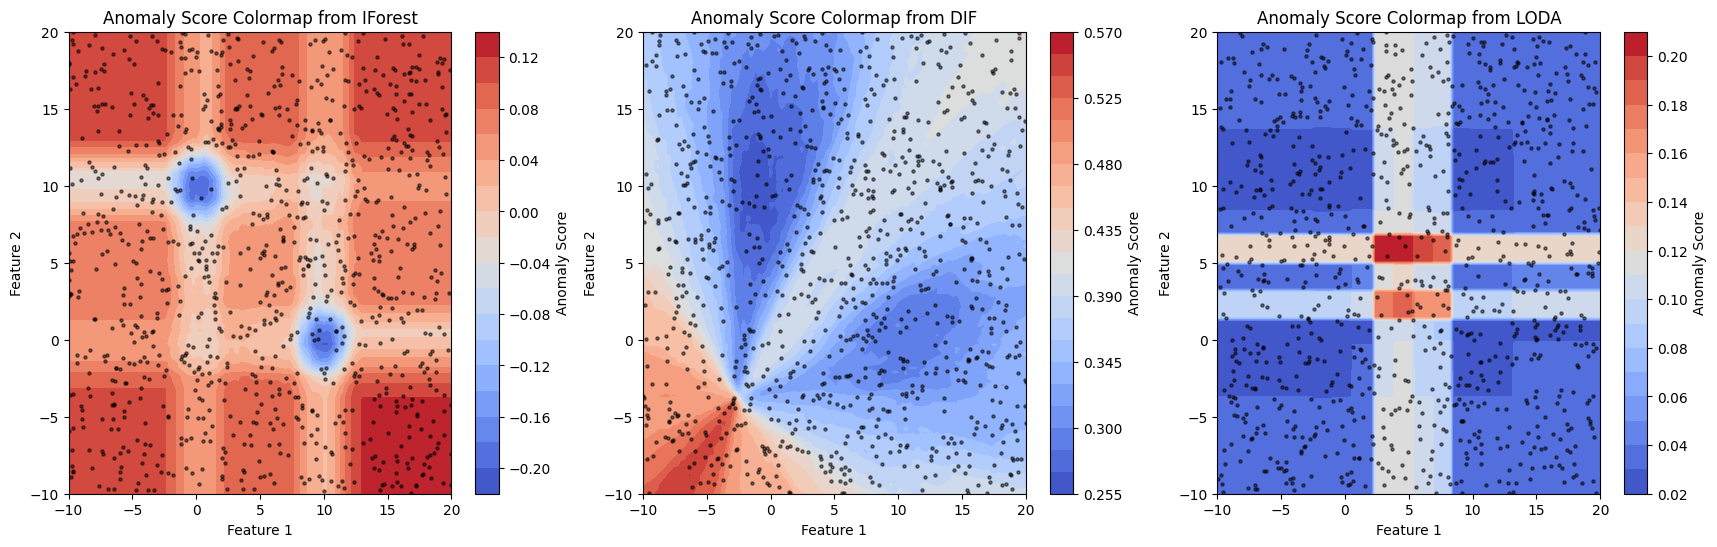

In [50]:
#Ex 2.5
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

colors(p=0,model=IF)
colors(p=1,model=DIF,neurons=5)
colors(p=2,model=LODA,bins=20)




<ipython-input-51-4a5c89443e5a>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[:, 0], x[:, 1], x[:, 2], cmap='viridis', s=6)


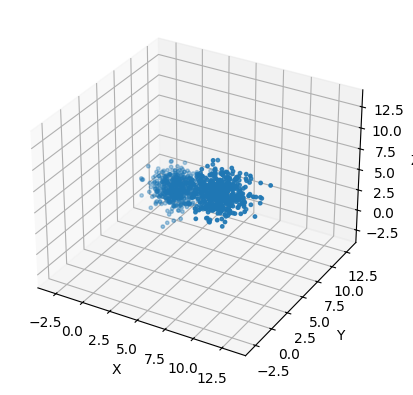

In [51]:
#Ex 2.6

miu_1=np.array([0,10,0])
miu_2=np.array([10,0,10])
x,_=make_blobs([500,500],n_features=3,centers=[miu_1,miu_2], cluster_std=[1,1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x[:, 0], x[:, 1], x[:, 2], cmap='viridis', s=6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

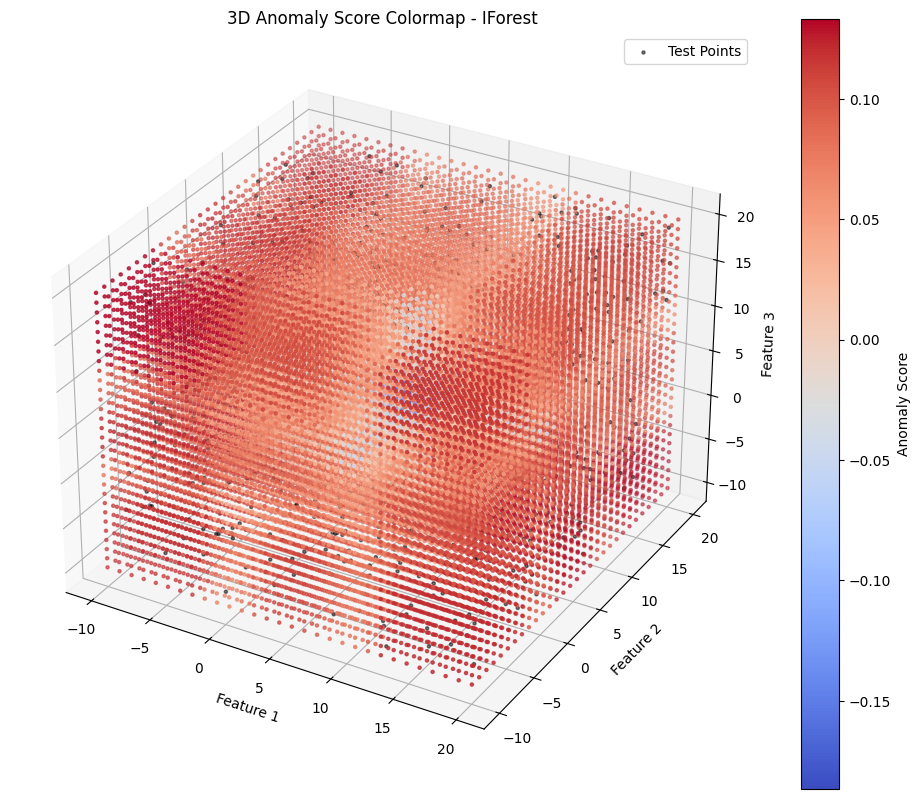

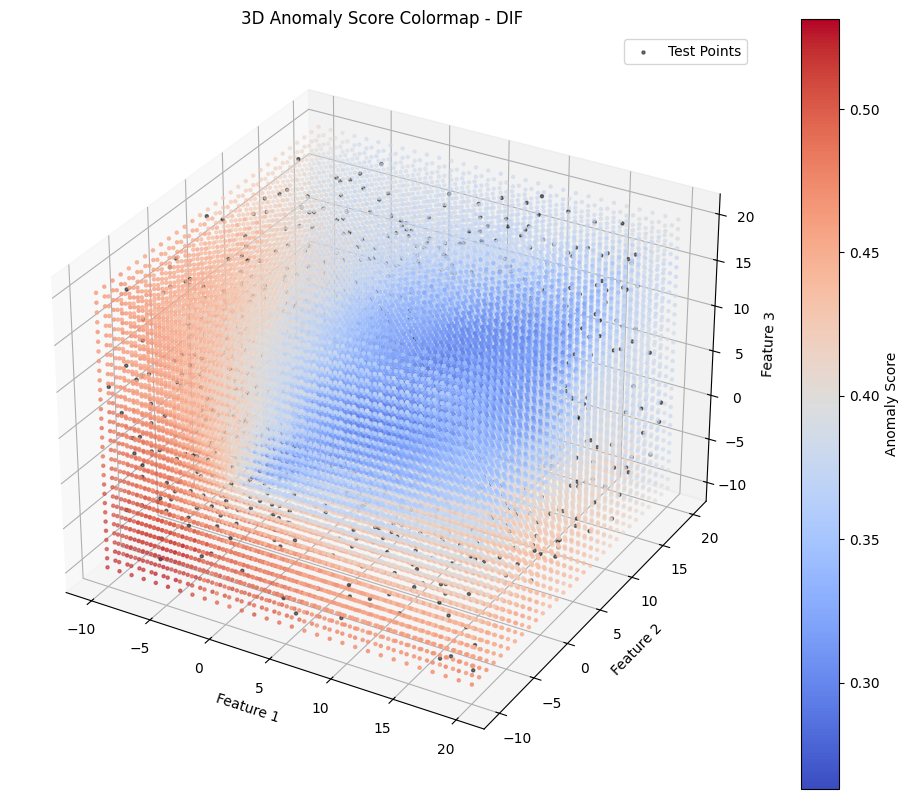

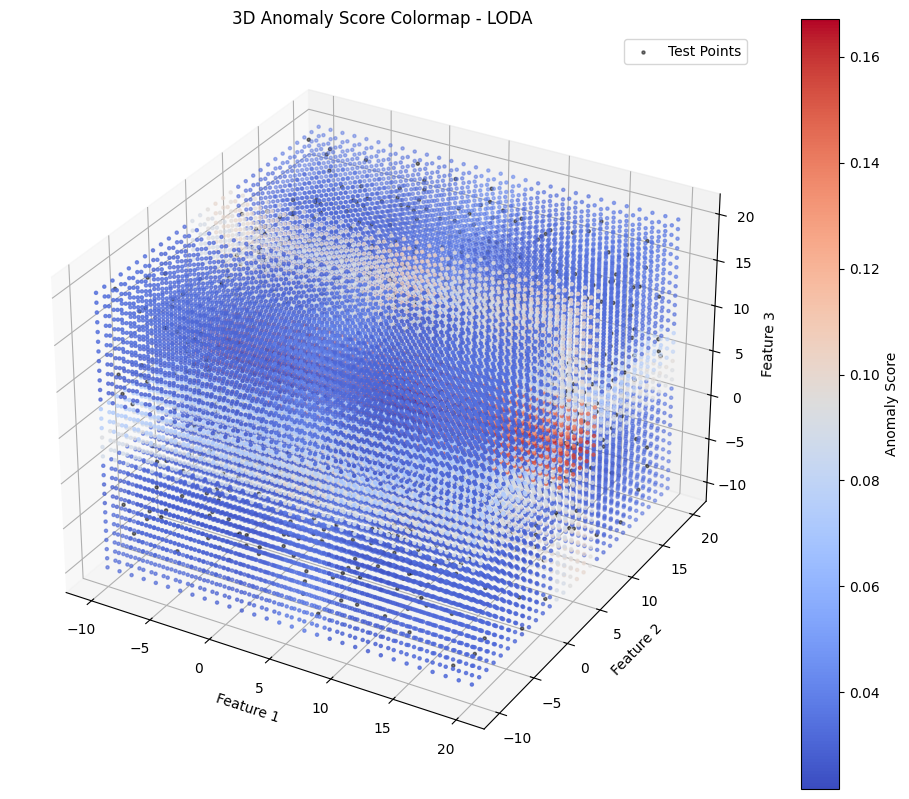

In [52]:

def colors_3d(p, model, neurons=0, bins=10):
    # Initialize the anomaly detection model
    if model == IF:
        forest = model(contamination=0.02)
        nume = 'IForest'
    elif model == DIF:
        nume = 'DIF'
        if neurons != 0:
            forest = model(contamination=0.02, hidden_neurons=neurons)
        else:
            forest = model(contamination=0.02)
    elif model == LODA:
        forest = model(contamination=0.02, n_bins=bins)
        nume = 'LODA'

    # Fit the model
    forest.fit(x)

    # Generate test points
    x_test = np.random.uniform(low=-10, high=20, size=(1000, 3))

    # Generate grid points for 3D anomaly score visualization
    x_min, x_max = -10, 20
    y_min, y_max = -10, 20
    z_min, z_max = -10, 20
    xx, yy, zz = np.meshgrid(
        np.linspace(x_min, x_max, 30),
        np.linspace(y_min, y_max, 30),
        np.linspace(z_min, z_max, 30)
    )

    # Flatten the grid and calculate anomaly scores
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    scores = forest.decision_function(grid_points)

    # Create a 3D scatter plot of the scores
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Map scores to colors
    scatter = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], c=scores, cmap='coolwarm', s=5)
    plt.colorbar(scatter, ax=ax, label="Anomaly Score")

    # Overlay test points
    ax.scatter(x_test[:, 0], x_test[:, 1], x_test[:, 2], c='black', s=5, alpha=0.5, label='Test Points')

    # Set labels and title
    ax.set_title(f"3D Anomaly Score Colormap - {nume}")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    ax.legend()

    plt.show()

# Example usage:
colors_3d(p=0, model=IF)
colors_3d(p=1, model=DIF)
colors_3d(p=2, model=LODA)


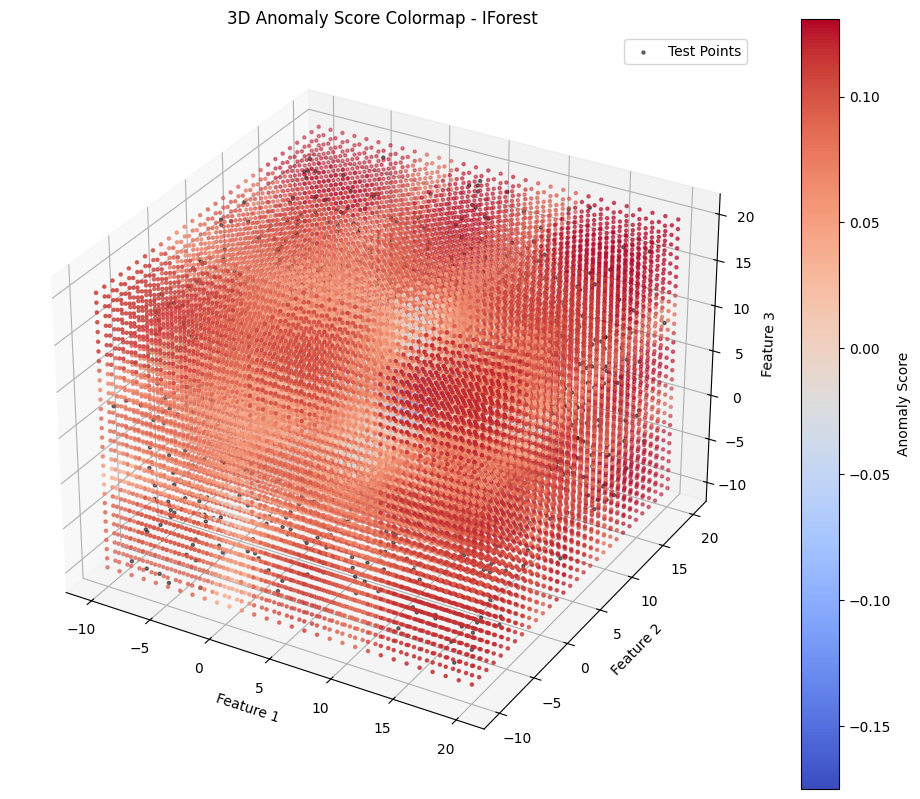

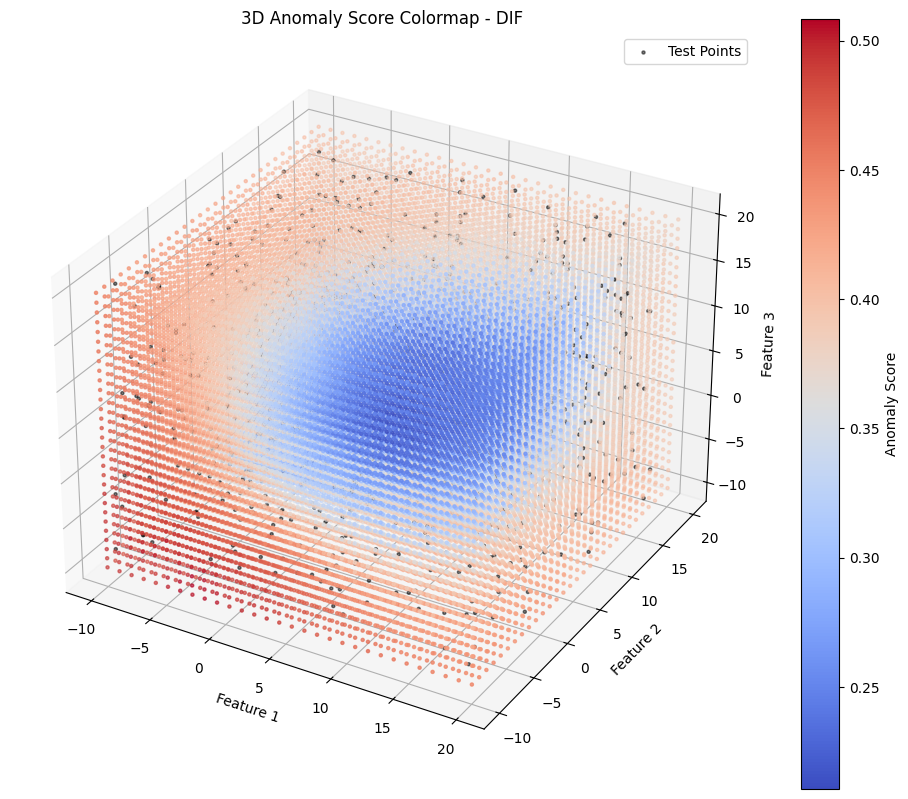

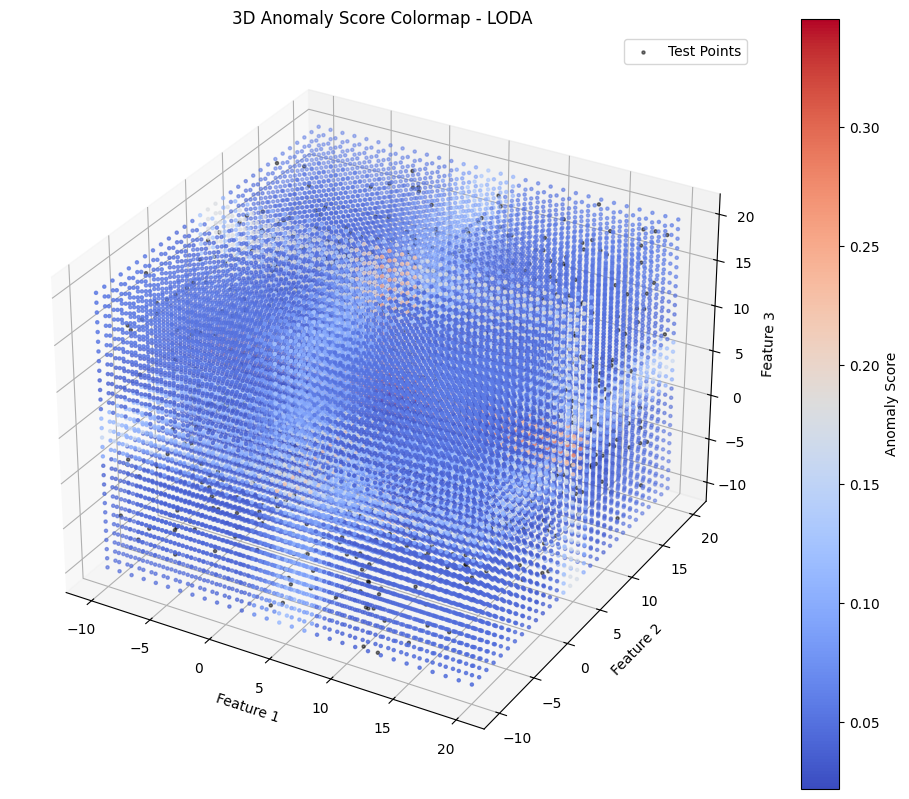

In [ ]:

colors_3d(p=0,model=IF)
colors_3d(p=1,model=DIF,neurons=[5])
colors_3d(p=2,model=LODA,bins=20)



In [31]:
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import roc_auc_score as ras

def BA(Y,Y_pred):
  cm = confusion_matrix(Y, Y_pred)

  TN, FP, FN, TP = cm.ravel()

  TPR = TP / (TP + FN)
  TNR = TN / (TN + FP)

  balanced_accuracy = (TPR + TNR) / 2
  return balanced_accuracy


def Model(model,cont, x_test,y_test, neurons=0, bins=10):
    # Initialize the anomaly detection model
    if model == IF:
        forest = model(contamination=cont)
        nume = 'IForest'
    elif model == DIF:
        nume = 'DIF'
        if neurons != 0:
            forest = model(contamination=cont, hidden_neurons=neurons)
        else:
            forest = model(contamination=cont)
    elif model == LODA:
        forest = model(contamination=cont, n_bins=bins)
        nume = 'LODA'

    forest.fit(x_test)

    y_test_pred=forest.predict(x_test)
    y_test_scores = forest.decision_function(X_test)


    #BA Pentru test
    balanced_accuracy_test = BA(y_test,y_test_pred)
    auc_score = ras(y_test, y_test_scores)

    return balanced_accuracy_test, auc_score




In [32]:
data = loadmat('shuttle.mat')
i=1
print(data.keys())

X = data['X']  # replace 'X' with the correct key if different
y = data['y']  # replace 'y' with the correct key if different




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


"""print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)"""

if_ba=[]
if_auc=[]

dif_ba=[]
dif_auc=[]

loda_ba=[]
loda_auc=[]

for i in range(1,11):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
  #Normalizez datele
  X_train, X_test = standardizer(X_train, X_test)

  p_train,p_test=y_train[y_train==1].shape[0]/y_train.shape[0], y_test[y_test==1].shape[0]/y_test.shape[0]

  print("La split-ul {}: \n {:.4f} % din Train sunt anomalii. \n {:.4f} % din Test sunt anomalii. \n".format(i,p_train,p_test))

  a,b=Model(IF, p_train, X_test, y_test)
  if_ba.append(a)
  if_auc.append(b)

  a,b=Model(DIF, p_train, X_test, y_test)
  dif_ba.append(a)
  dif_auc.append(b)

  a,b=Model(LODA, p_train, X_test, y_test)
  loda_ba.append(a)
  loda_auc.append(b)

for [nume,ba,auc] in [["IF",if_ba,if_auc], ["DIF",dif_ba,dif_auc], ["LODA",loda_ba,loda_auc]]:
  print("\n Pentru modelul {} : \n Balanced accurary = {:.4f} \n AUC = {:.4f}".format(nume,np.mean(ba), np.mean(auc)))

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
La split-ul 1: 
 0.0710 % din Train sunt anomalii. 
 0.0723 % din Test sunt anomalii. 

La split-ul 2: 
 0.0708 % din Train sunt anomalii. 
 0.0726 % din Test sunt anomalii. 

La split-ul 3: 
 0.0718 % din Train sunt anomalii. 
 0.0710 % din Test sunt anomalii. 

La split-ul 4: 
 0.0723 % din Train sunt anomalii. 
 0.0704 % din Test sunt anomalii. 

La split-ul 5: 
 0.0702 % din Train sunt anomalii. 
 0.0735 % din Test sunt anomalii. 

La split-ul 6: 
 0.0698 % din Train sunt anomalii. 
 0.0740 % din Test sunt anomalii. 

La split-ul 7: 
 0.0712 % din Train sunt anomalii. 
 0.0719 % din Test sunt anomalii. 

La split-ul 8: 
 0.0724 % din Train sunt anomalii. 
 0.0702 % din Test sunt anomalii. 

La split-ul 9: 
 0.0709 % din Train sunt anomalii. 
 0.0724 % din Test sunt anomalii. 

La split-ul 10: 
 0.0713 % din Train sunt anomalii. 
 0.0718 % din Test sunt anomalii. 


 Pentru modelul IF : 
 Balanced accurary = 0.9676 
 